In [198]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
import pandas as pd
import math 
import csv
import time
import dateutil
from datetime import datetime
import seaborn as sns

          
pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")
        


# Load Original Dataset

In [199]:
switchesdf = pd.read_csv("./Political Party Switches/nova_tabela.csv", dtype={"mb": np.int32}, parse_dates=True)
classificationsdf = pd.read_csv("./Political Party Switches/party_classifications.csv", dtype={"party_id": np.int32}, parse_dates=True)

In [200]:
switchesdf.drop(["prior_party_id","prior_party_name",
                 "appointment","same_person","party_change"], axis=1, inplace=1, errors="ignore")

switchesdf.drop(switchesdf[switchesdf.pres_name.isnull() & switchesdf.party_id.isnull()].index, axis=0, inplace=1)

In [201]:
switchesdf.date = pd.to_datetime(switchesdf.date, format="%Y-%m-%d")

In [223]:
#switchesdf.head()

In [224]:
switchesdf.mun_id = switchesdf.mun_id.astype(int)
switchesdf.party_id = switchesdf.party_id.astype(int) 
#switchesdf.info()

In [222]:
#classificationsdf.info()

# Expand to paneldf (day-by-day)

### Daily Panel Data

In [205]:
# daily panel
# initialize panel dataframe 
dpaneldf = pd.DataFrame()

# get all municipalities
mbs = switchesdf.mun_id.unique()

# add panel data from each municipality to main paneldf 
for mb in mbs:
    
    #append a 2016 date
    df = switchesdf[switchesdf.mun_id == mb].append({"mun_id":mb,"mun": "","party_id":-2,
                                           "date":pd.to_datetime("2016-04-03")}, ignore_index=True)
    
    df = df.sort_values("date").set_index("date")
    df = df.asfreq(pd.DateOffset(days=1), method='pad')
    df = df.reset_index()
    dpaneldf = dpaneldf.append(df, ignore_index=True)

In [225]:
print dpaneldf.shape
#dpaneldf.head()

(277450, 17)


In [207]:
dpaneldf = dpaneldf.merge(classificationsdf, on="party_id")

In [208]:
print dpaneldf.shape
dpaneldf.head()

(277450, 18)


,date,mun_id,mun,pres_name,party_id,party_abr,name_abr,name_full,in_gov11,ingov12,ingov14,ag1_name_abr,ag1_party_id,ag1_name_full,ag2_name_abr,ag2_party_id,ag2_name_full,nat_party
0,2008-05-23,70033,Arandjelovac,Vlada Gajic,2,DS,DS,Demokratska Stranka,1,0,0,DS,2,Demokratska Stranka,DS,2,Demokratska Stranka,1
1,2008-05-24,70033,Arandjelovac,Vlada Gajic,2,DS,DS,Demokratska Stranka,1,0,0,DS,2,Demokratska Stranka,DS,2,Demokratska Stranka,1
2,2008-05-25,70033,Arandjelovac,Vlada Gajic,2,DS,DS,Demokratska Stranka,1,0,0,DS,2,Demokratska Stranka,DS,2,Demokratska Stranka,1
3,2008-05-26,70033,Arandjelovac,Vlada Gajic,2,DS,DS,Demokratska Stranka,1,0,0,DS,2,Demokratska Stranka,DS,2,Demokratska Stranka,1
4,2008-05-27,70033,Arandjelovac,Vlada Gajic,2,DS,DS,Demokratska Stranka,1,0,0,DS,2,Demokratska Stranka,DS,2,Demokratska Stranka,1


In [221]:
#dpaneldf.ag2_name_full.unique()

In [220]:
#dpaneldf.info()

In [211]:
# drop empty column
dpaneldf.drop("party_abr", axis=1,inplace=1, errors='ignore')

# save to csv
dpaneldf.to_csv("./exports/daily_political_full_detail.csv")

### Make Monthly Panel Data

In [212]:
#monthly panel
%time
# define mode function for below
def mode_(s):
    try:
        return s.mode()[0]
    except IndexError:
        return np.nan

# initialize panel dataframe 
mpaneldf = pd.DataFrame()

# get all municipalities
mbs = switchesdf.mun_id.unique()

# add panel data from each municipality to main paneldf 
for mat in mbs:
    
    #append a 2016 date
    df = switchesdf[switchesdf.mun_id == mat].append({"mun_id":mat,"mun": "","party_id":-2,"party_abr":"",
                                           "prior_party_id":-2,"prior_party_name":"",
                                           "date":pd.to_datetime("2016-04-03")}, ignore_index=True)

    # expand to daily values
    df = df.sort_values("date").set_index("date")
    df = df.asfreq(pd.DateOffset(days=1), method='pad')
    
    # collaps to monthly values
    df = df.resample("M", how={"party_id": mode_, 
                               "party_abr": mode_,
                               "mun": mode_, 
                               "mun_id": mode_,
                               "pres_name": mode_})
    df = df.reset_index()
    mpaneldf = mpaneldf.append(df, ignore_index=True)

Wall time: 0 ns


C:\Users\nolefp\Anaconda\lib\site-packages\ipykernel\__main__.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


In [226]:
print mpaneldf.shape
#mpaneldf.head()

(9246, 17)


In [214]:
mpaneldf = mpaneldf.merge(classificationsdf, on="party_id")

In [215]:
mpaneldf.head()

,date,pres_name,mun,party_id,party_abr,mun_id,name_abr,name_full,in_gov11,ingov12,ingov14,ag1_name_abr,ag1_party_id,ag1_name_full,ag2_name_abr,ag2_party_id,ag2_name_full,nat_party
0,2008-05-31,Vlada Gajic,Arandjelovac,2.0,DS,70033.0,DS,Demokratska Stranka,1,0,0,DS,2,Demokratska Stranka,DS,2,Demokratska Stranka,1
1,2008-06-30,Vlada Gajic,Arandjelovac,2.0,DS,70033.0,DS,Demokratska Stranka,1,0,0,DS,2,Demokratska Stranka,DS,2,Demokratska Stranka,1
2,2008-07-31,Vlada Gajic,Arandjelovac,2.0,DS,70033.0,DS,Demokratska Stranka,1,0,0,DS,2,Demokratska Stranka,DS,2,Demokratska Stranka,1
3,2008-08-31,Vlada Gajic,Arandjelovac,2.0,DS,70033.0,DS,Demokratska Stranka,1,0,0,DS,2,Demokratska Stranka,DS,2,Demokratska Stranka,1
4,2008-09-30,Vlada Gajic,Arandjelovac,2.0,DS,70033.0,DS,Demokratska Stranka,1,0,0,DS,2,Demokratska Stranka,DS,2,Demokratska Stranka,1


In [227]:
for col in mpaneldf.columns:
    if re.search("_id", col):
        mpaneldf[col] = mpaneldf[col].astype(int)
#mpaneldf.info()

In [217]:
# drop empty column
mpaneldf.drop("party_abr", axis=1,inplace=1, errors='ignore')

# save to csv
mpaneldf.to_csv("./exports/monthly_political_full_detail.csv")

### Annual Panel Data

In [218]:
# annual panel
# define mode function for below

def mode_(s):
    try:
        return s.mode()[0]
    except IndexError:
        return np.nan

# initialize panel dataframe 
apaneldf = pd.DataFrame()

# get all municipalities
mbs = switchesdf.mun_id.unique()

# add panel data from each municipality to main paneldf 
for mat in mbs:
    
    #append a 2016 date
    df = switchesdf[switchesdf.mun_id == mat].append({"mun_id":mat,"mun": "","party_id":-2,"party_abr":"",
                                           "prior_party_id":-2,"prior_party_name":"",
                                           "date":pd.to_datetime("2016-04-03")}, ignore_index=True)

    # expand to daily values
    df = df.sort_values("date").set_index("date")
    df = df.asfreq(pd.DateOffset(days=1), method='pad')
    
    # collaps to monthly values
    df = df.resample("AS", how={"party_id": mode_, 
                               "party_abr": mode_,
                               "mun": mode_, 
                               "mun_id": mode_,
                               "pres_name": mode_})
    df = df.reset_index()
    apaneldf = apaneldf.append(df, ignore_index=True)


C:\Users\nolefp\Anaconda\lib\site-packages\ipykernel\__main__.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


In [219]:
apaneldf = apaneldf.merge(classificationsdf, on="party_id")

In [229]:
#print apaneldf.info()
#apaneldf.head()

In [137]:
# drop empty column
apaneldf.drop("party_abr", axis=1,inplace=1, errors='ignore')

# save to csv
apaneldf.to_csv("./exports/annual_political_full_detail.csv")

# Visualizations

## Party Totals over Time

### Party Changes

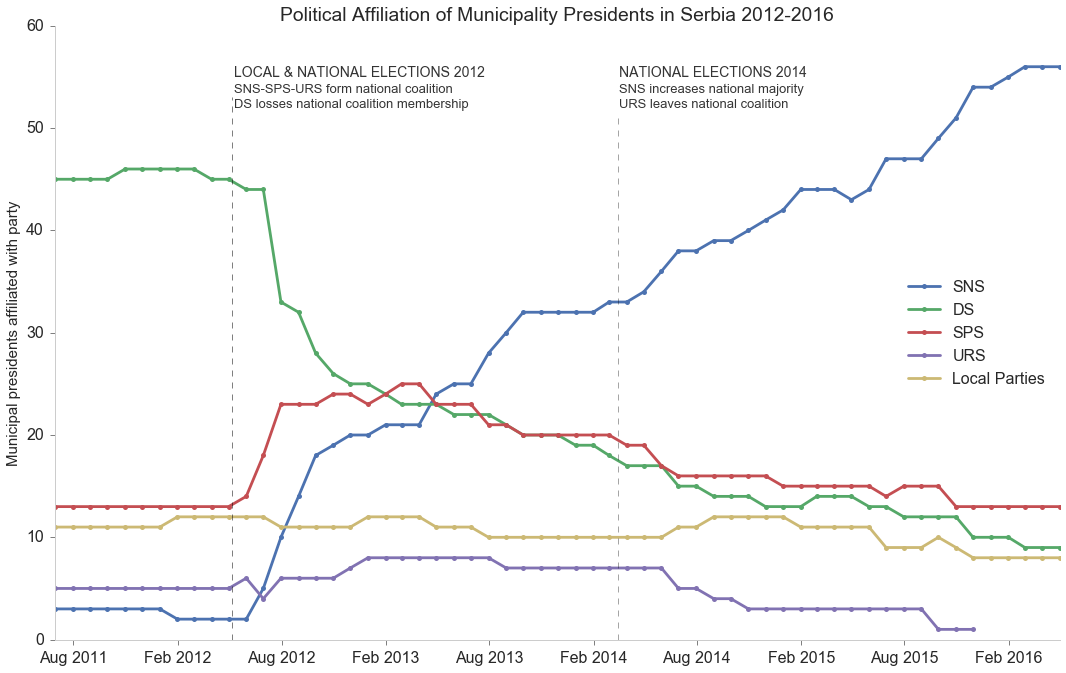

In [140]:
#graph code
totals_by_party = mpaneldf.groupby(["ag2_name_abr","date"]).mun_id.count().reset_index()

fig, ax = plt.subplots(figsize=(18,11))
#colormap = plt.cm.gist_ncar
#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, 15)])

parties_main = ["SNS","DS","SPS","URS","LP"]

# start date from which to plot
start_date = pd.to_datetime("2011-06-01")

for party in parties_main:
    x= totals_by_party[(totals_by_party.date > start_date) & (totals_by_party.ag2_name_abr == party)].date
    y= totals_by_party[(totals_by_party.date > start_date) & (totals_by_party.ag2_name_abr == party)].mun_id
   
    plt.plot_date(x,y, 'o-', markersize=5, label=party)

# election 2012
plt.axvline(pd.to_datetime("2012-05-06"),ymax=53./60, ls='dashed', lw=1, color='black', alpha=.5)
plt.text(pd.to_datetime("2012-05-10"),55,'Local & National Elections 2012'.upper(), alpha=.8, fontsize=14, color='black')
plt.text(pd.to_datetime("2012-05-10"),53.5,'SNS-SPS-URS form national coalition', alpha=.8, fontsize=13, color='black')
plt.text(pd.to_datetime("2012-05-10"),52,'DS losses national coalition membership', alpha=.8, fontsize=13, color='black')

# election 2014
plt.axvline(pd.to_datetime("2014-03-16"),ymax=51.5/60, ls='dashed', lw=.7, color='black', alpha=.5)
plt.text(pd.to_datetime("2014-03-17"),55,'National Elections 2014'.upper(), fontsize=14, alpha=.8, color='black')
plt.text(pd.to_datetime("2014-03-17"),53.5,'SNS increases national majority', fontsize=13, alpha=.8, color='black')
plt.text(pd.to_datetime("2014-03-17"),52,'URS leaves national coalition', fontsize=13, alpha=.8, color='black')

# plot options
title = "Political Affiliation of Municipality Presidents in Serbia 2012-2016"
plt.title(title)
plt.ylabel("Municipal presidents affiliated with party", fontsize=15)
plt.grid()
plt.legend(labels=["SNS","DS","SPS","URS","Local Parties"],loc=7)


# axes options
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x',which='major', direction='out', width=1,length=5,bottom='on',top="off",color='grey')
ax.tick_params(axis='y',which='major', direction='out', width=1,length=5,left='on',right="off",color='grey')
ax.tick_params(axis='y',which='minor', direction='out', width=1,length=3,left='on',right="off",color='grey')

# save
plt.savefig("./exports/" + title)

<script type='text/javascript' src='https://public.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1019px; height: 979px;'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Po&#47;PolitickaPripadnostKrozVreme&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz' width='1019' height='979' style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='PolitickaPripadnostKrozVreme&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Po&#47;PolitickaPripadnostKrozVreme&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='showTabs' value='y' /></object></div>

### Other Vis

In [ ]:
mpaneldf.info()

In [ ]:
mpaneldf.ingov12.unique()

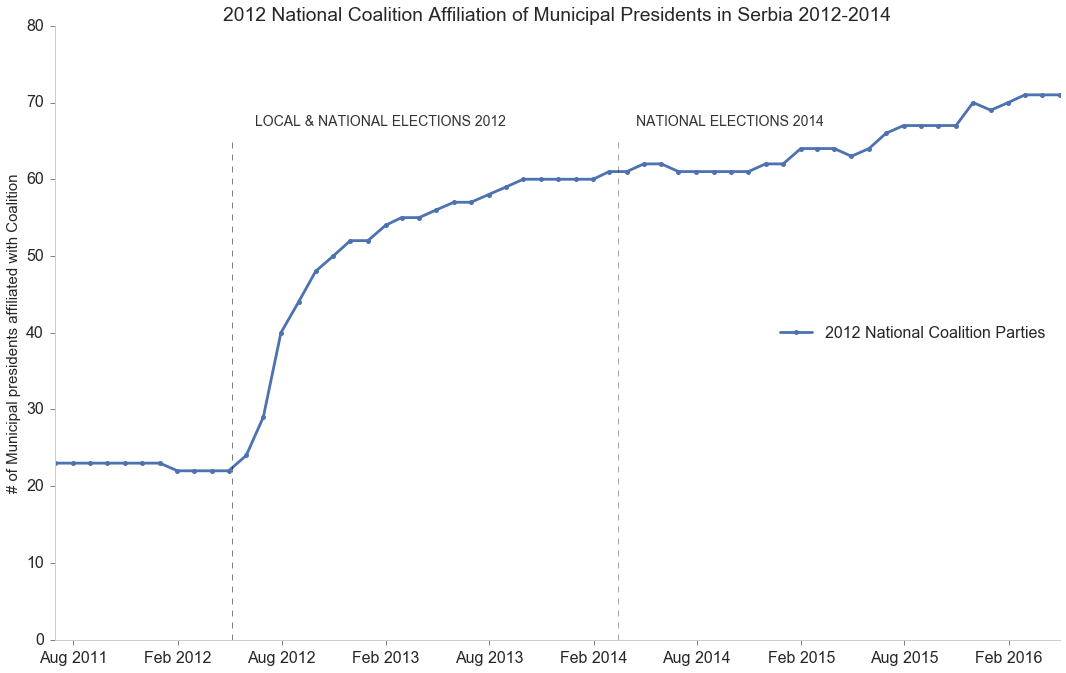

In [141]:
# graph code
totals_by_party = mpaneldf.groupby(["ingov12","date"]).mun_id.count().reset_index()

fig, ax = plt.subplots(figsize=(18,11))
#colormap = plt.cm.gist_ncar
#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, 15)])

# start date from which to plot
start_date = pd.to_datetime("2011-06-01")

party = mpaneldf.ingov12.unique()[1]
x= totals_by_party[(totals_by_party.date > start_date) & (totals_by_party.ingov12 == party)].date
y= totals_by_party[(totals_by_party.date > start_date) & (totals_by_party.ingov12 == party)].mun_id

plt.plot_date(x,y, 'o-', markersize=5, label=party)

# election 2012
height = 65.
plt.axvline(pd.to_datetime("2012-05-06"),ymax=height/80, ls='dashed', lw=1, color='black', alpha=.5)
plt.text(pd.to_datetime("2012-06-15"),height+2,'Local & National Elections 2012'.upper(), alpha=.8, fontsize=14, color='black')


# election 2014
plt.axvline(pd.to_datetime("2014-03-16"),ymax=height/80, ls='dashed', lw=.7, color='black', alpha=.5)
plt.text(pd.to_datetime("2014-04-17"),height+2,'National Elections 2014'.upper(), fontsize=14, alpha=.8, color='black')


# plot options
title = "2012 National Coalition Affiliation of Municipal Presidents in Serbia 2012-2014"
plt.title(title)
plt.ylabel("# of Municipal presidents affiliated with Coalition", fontsize=15)
plt.grid()
plt.legend(["2012 National Coalition Parties"], loc=7)
plt.ylim(ymin=0)

# axes options
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x',which='major', direction='out', width=1,length=5,bottom='on',top="off",color='grey')
ax.tick_params(axis='y',which='major', direction='out', width=1,length=5,left='on',right="off",color='grey')
ax.tick_params(axis='y',which='minor', direction='out', width=1,length=3,left='on',right="off",color='grey')

# save
plt.savefig("./exports/" + title)

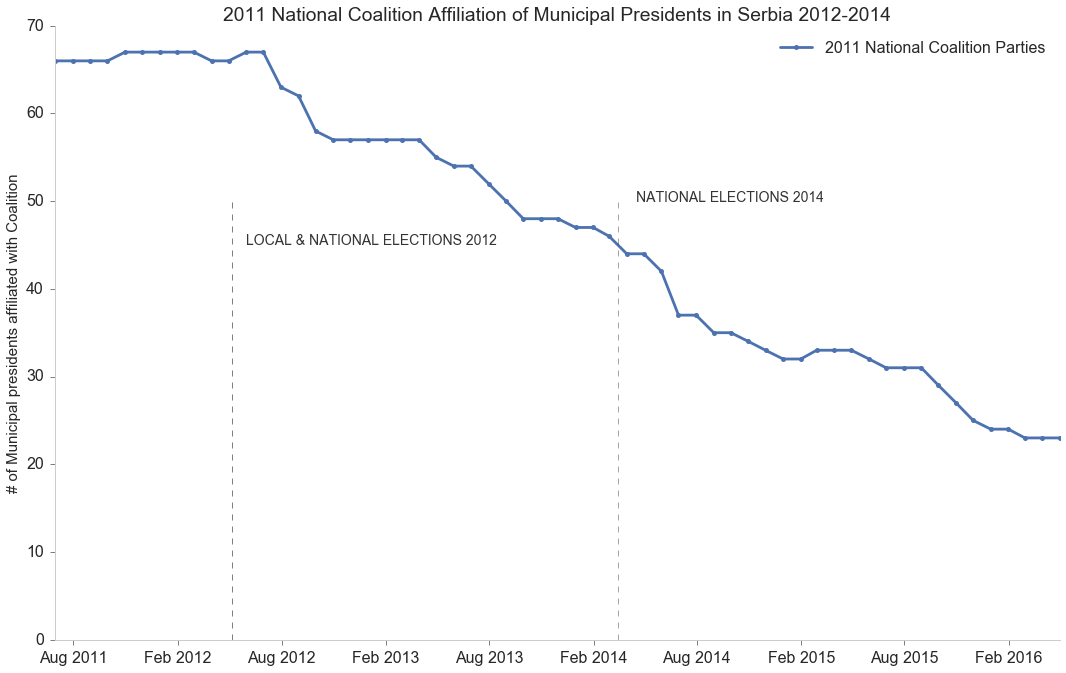

In [142]:
# graph code
totals_by_party = mpaneldf.groupby(["in_gov11","date"]).mun_id.count().reset_index()

fig, ax = plt.subplots(figsize=(18,11))
#colormap = plt.cm.gist_ncar
#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, 15)])

# start date from which to plot
start_date = pd.to_datetime("2011-06-01")

party = mpaneldf.in_gov11.unique()[0]
x= totals_by_party[(totals_by_party.date > start_date) & (totals_by_party.in_gov11 == party)].date
y= totals_by_party[(totals_by_party.date > start_date) & (totals_by_party.in_gov11 == party)].mun_id

plt.plot_date(x,y, 'o-', markersize=5, label=party)


lineh = 40.
height = 70
# election 2012
plt.axvline(pd.to_datetime("2012-05-06"),ymax=(lineh+10)/height, ls='dashed', lw=1, color='black', alpha=.5)
plt.text(pd.to_datetime("2012-05-30"),lineh+5,'Local & National Elections 2012'.upper(), alpha=.8, fontsize=14, color='black')

# election 2014
plt.axvline(pd.to_datetime("2014-03-16"),ymax=(lineh+10)/height, ls='dashed', lw=.7, color='black', alpha=.5)
plt.text(pd.to_datetime("2014-04-17"),lineh+10,'National Elections 2014'.upper(), fontsize=14, alpha=.8, color='black')


# plot options
title = "2011 National Coalition Affiliation of Municipal Presidents in Serbia 2012-2014"
plt.title(title)
plt.ylabel("# of Municipal presidents affiliated with Coalition", fontsize=15)
plt.grid()
plt.legend(["2011 National Coalition Parties"], loc=1)
plt.ylim(ymin=0)


# axes options
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x',which='major', direction='out', width=1,length=5,bottom='on',top="off",color='grey')
ax.tick_params(axis='y',which='major', direction='out', width=1,length=5,left='on',right="off",color='grey')
ax.tick_params(axis='y',which='minor', direction='out', width=1,length=3,left='on',right="off",color='grey')

# save
plt.savefig("./exports/" + title)

# Special Measures

## Pre-Election 2012

In [ ]:
# get who was in power 6 months prior to election in 2012
paneldf_pre2012 = paneldf[(pd.to_datetime("2012-01-01") < paneldf.date ) & (paneldf.date < pd.to_datetime("2012-05-01"))]

# get parties who were longest in power during this period
inpower_2012_df = paneldf_pre2012.groupby('mb').party_id.agg(lambda x:x.value_counts().index[0])
inpower_2012_df = pd.DataFrame(inpower_2012_df).reset_index()
inpower_2012_df.head()

In [ ]:
# re-apply names 
inpower_2012_df = inpower_2012_df.merge(classificationsdf, on="party_id")

### sanity check

In [ ]:
inpower_2012_df.head()

In [ ]:
inpower_2012_df.name_abr.value_counts()

In [ ]:
# export the dataframe
inpower_2012_df.to_csv("./Political Party Switches/inpower_preelec_2012.csv")